In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oindrilapaul684","key":"d1494ef6f438fa2ef49ad4eadcc30321"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d robinreni/signature-verification-dataset

Dataset URL: https://www.kaggle.com/datasets/robinreni/signature-verification-dataset
License(s): CC0-1.0
100% 601M/601M [00:08<00:00, 25.7MB/s]
100% 601M/601M [00:08<00:00, 75.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/signature-verification-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K

In [ ]:
# Define the base directory where images are stored
base_dir = "/content/sign_data/train/"

# Load CSV file
df = pd.read_csv("/content/sign_data/train_data.csv", header=None)
df= df.sample(frac=0.9, random_state=42)
df.columns = ["real_signature_path", "test_signature_path", "label"]

df.shape

(20885, 3)

In [ ]:
# Function to load and preprocess a single image
def load_image(image_path):
    full_path = os.path.join(base_dir, image_path)
    img = cv2.imread(full_path)
    if img is None:
        print(f"Warning: Could not read image {full_path}")
        return None
    img = cv2.resize(img, (224, 224))  # Reduce size to save memory
    img = preprocess_input(img)  # Normalize for VGG16
    return img


In [ ]:
class SignatureDataGenerator(Sequence):
    def __init__(self, df, batch_size=16):
        self.df = df
        self.batch_size = batch_size
        self.indices = np.arange(len(df))

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X1, X2, Y = [], [], []

        for i in batch_indices:
            row = self.df.iloc[i]
            imgA = load_image(row["real_signature_path"])
            imgB = load_image(row["test_signature_path"])
            label = row["label"]

            if imgA is not None and imgB is not None:
                X1.append(imgA)
                X2.append(imgB)
                Y.append(label)

        return (np.array(X1, dtype=np.float32), np.array(X2, dtype=np.float32)), np.array(Y, dtype=np.float32)

# Create training data generator
train_generator = SignatureDataGenerator(df, batch_size=16)

# Load test CSV file
test_df = pd.read_csv("/content/sign_data/test_data.csv", header=None)
test_df.columns = ["real_signature_path", "test_signature_path", "label"]

# Create test data generator
test_generator = SignatureDataGenerator(test_df, batch_size=16)

In [ ]:
# # Load Pretrained VGG16 Model
# base_model = VGG16(weights="imagenet", include_top=True)
# feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer("fc2").output)

# # Freeze VGG16 layers to prevent training
# for layer in base_model.layers:
#     layer.trainable = False

# # Define Inputs
# inputA = Input(shape=(224, 224, 3))
# inputB = Input(shape=(224, 224, 3))

# # Extract features using VGG16
# featA = feature_extractor(inputA)
# featB = feature_extractor(inputB)

# # Compute Euclidean distance
# def euclidean_distance(vectors):
#     x, y = vectors
#     return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

# distance = Lambda(euclidean_distance)([featA, featB])
# # Fully connected layer for binary classification
# output = Dense(1, activation="sigmoid")(distance)

# # Define Siamese Model
# siamese_model = Model(inputs=[inputA, inputB], outputs=output)

# # Compile Model
# siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# # Train the Siamese Network
# siamese_model.fit(train_generator, epochs=9)

#removed last 10k data


In [ ]:
# # Load test CSV file
# test_df = pd.read_csv("/content/sign_data/test_data.csv", header=None)
# test_df.columns = ["real_signature_path", "test_signature_path", "label"]



In [ ]:
# test_df.shape


(5748, 3)

In [ ]:
# test_generator = SignatureDataGenerator(test_df, batch_size=16)

In [ ]:
# Load Pretrained VGG16 Model
base_model = VGG16(weights="imagenet", include_top=True)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer("fc2").output)

# Freeze VGG16 layers to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Define Inputs
inputA = Input(shape=(224, 224, 3))
inputB = Input(shape=(224, 224, 3))

# Extract features using VGG16
featA = feature_extractor(inputA)
featB = feature_extractor(inputB)

# Compute Euclidean distance
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

distance = Lambda(euclidean_distance)([featA, featB])

# Fully connected layer for binary classification
output = Dense(1, activation="sigmoid")(distance)

# Define Siamese Model
siamese_model = Model(inputs=[inputA, inputB], outputs=output)

# Compile Model
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the Siamese Network
history = siamese_model.fit(train_generator, validation_data=test_generator, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 364s 263ms/step - accuracy: 0.4802 - loss: 6.3140 - val_accuracy: 0.7363 - val_loss: 0.6292
Epoch 2/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 343s 263ms/step - accuracy: 0.7342 - loss: 0.6360 - val_accuracy: 0.7611 - val_loss: 0.6120
Epoch 3/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 333s 255ms/step - accuracy: 0.7493 - loss: 0.6165 - val_accuracy: 0.7777 - val_loss: 0.5938
Epoch 4/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 333s 255ms/step - accuracy: 0.7573 - loss: 0.5920 - val_accuracy: 0.7761 - val_loss: 0.5742
Epoch 5/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 383s 255ms/step - accuracy: 0.7626 - loss: 0.5710 - val_accuracy: 0.7787 - val_loss: 0.5531
Epoch 6/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 382s 256ms/step - accuracy: 0.7719 - loss: 0.5524 - val_accuracy: 0.7784 - val_loss: 0.5352
Epoch 7/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 334s 255ms/step - accuracy: 0.7699 - loss: 0.5369 - val_accuracy: 0.7784 - val_loss: 0.5224
Epoch 8/10
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 343s 263ms/step - ac

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = siamese_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



360/360 ━━━━━━━━━━━━━━━━━━━━ 74s 206ms/step - accuracy: 0.8132 - loss: 0.4763
Test Loss: 0.5058, Test Accuracy: 0.7764


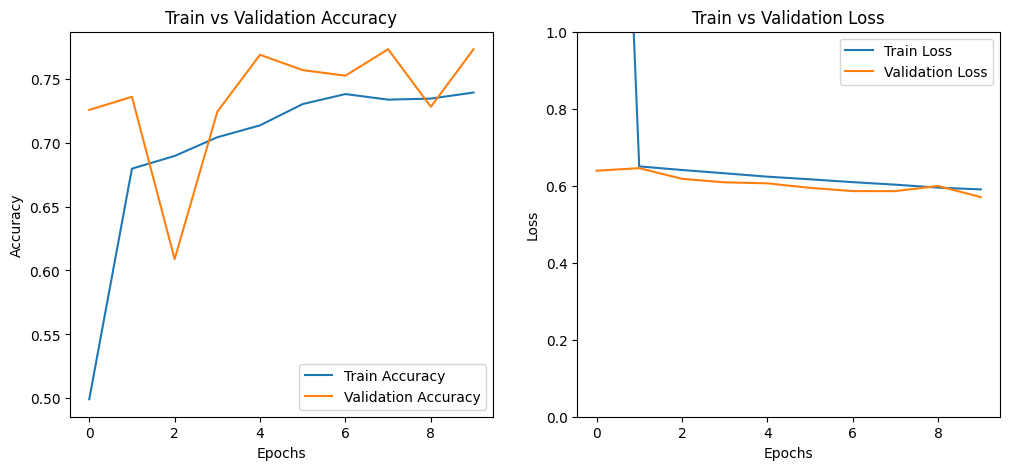

In [ ]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.ylim([0, 1])

plt.show()
